Uniqness analysis
===============

In this document we will analyze the precision and recall performance of `shark` depending on the number of uniq kmers in the genes.

## Data description

### Input data
We considered the 9403 genes from chromosomes 1, 17, and 21 of the Human Genome and we simulated a RNA-Seq sample of 10M 100-bp long reads using Flux Simulator.

### Shark parameters
We ran `shark` using the 10M reads as input and providing the annotation of all the 9403 genes.
`shark` was ran in both *single* and *multi* mode.
We recall that in single mode `shark` discard a read if it is assigned to multiple genes with the same score, whereas in multi mode both assignements are produced as output.

The kmer size used by `shark` was 17.

### Uniqness index
For each gene in the gene set we computed the set of distinct kmers appearing in the gene.  For each gene, each kmer is considered unique if it appears only in that gene, whereas the kmer is considered duplicated if it appears in at least one other gene.

For each gene we computed a uniqness index as the number of unique kmers in the gene over the number of distinct kmers in the gene.

We computed two versions of this index.
The first one considers as kmers of the gene all the kmers appearing in the gene region, thus considering kmers in the introns but not considering kmers overlapping splicing sites.
The second one considers as kmers of the gene all the kmers appearing in all the transcripts of the gene, thus considering the kmers overlapping splicing sites but not considering kmers in the introns.

We refer to the first index as *Uniqness index per gene* (UIPG) whereas we refer to the second index as *Uniqness index per transcript* (UIPT).

We computed the uniqness index of each gene for kmer size 13, 17, 23, 27, and 31.


We will now analyze whether the uniqness index of a gene affect `shark` performance.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, HTML, display_html, Markdown

kmer_lens = (13, 17, 23, 27, 31)
modes = ("single", "multi")

In [2]:
# Support function
def bins_limits(low, high, n=25):
    r = high - low
    bin_size = r / n
    return [low + bin_size * i for i in range(1, n+1)]

UIPG was precomputed for various kmer sizes and is stored in files `UIPG/[l].uniq_idx.tsv` where `l` is the length of the kmer.

UIPT was precomputed for various kmer sizes and is stored in files `UIPT/[l].gene.uniq_idx.tsv` where `l` is the length of the kmer.

Each line in the file reports the gene name, the number of uniq kmers, the total number of kmers, and the uniqness index.
Each value is separated by a TAB char.

In [3]:
UIPT = {}
UIPG = {}

for l in kmer_lens:
    UIPT[l] = pd.read_csv(f"UIPT/{l}.uniq_idx.tsv",
                          sep='\t',
                          header=None,
                          names=["gene", "uniq kmers", "total kmers", "UIPT"],
                          index_col=0)    
    UIPG[l] = pd.read_csv(f"UIPG/{l}.gene.uniq_idx.tsv",
                          sep='\t',
                          header=None,
                          names=["gene", "uniq kmers", "total kmers", "UIPG"],
                          index_col=0)

Let's first analyze the distribution of distinct index at both gene and transcript level.

## Distribution of distinct kmers in genes and in transcripts

We recall that the number of distinct kmers is the number of kmers appearing in each gene region or in all the transcripts of a gene.

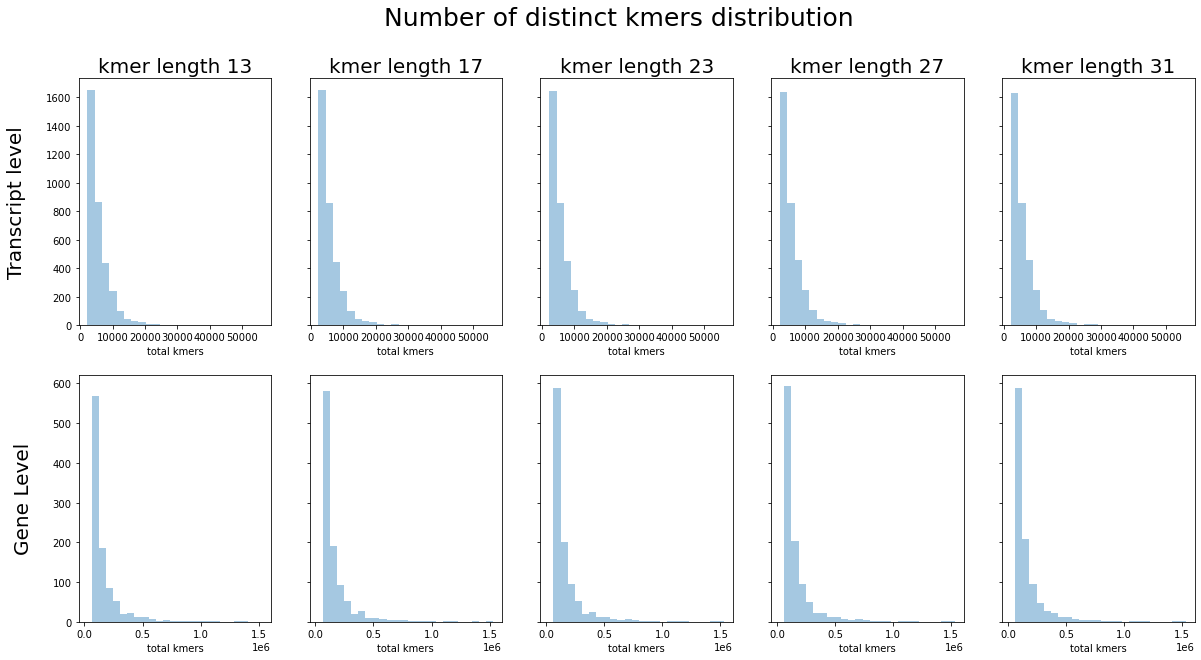

In [4]:
fig, big_axs = plt.subplots(2, 5,
                            sharey="row",
                            sharex="row",
                            figsize=[20,10]);

fig.suptitle("Number of distinct kmers distribution", fontsize=25);
big_axs[0][0].set_ylabel("Transcript level", fontsize=20, labelpad=20);
big_axs[1][0].set_ylabel("Gene Level", fontsize=20, labelpad=20);

mkpt = max((pd.to_numeric(UIPT[l]["total kmers"], errors="coerce").max() for l in kmer_lens))
mkpg = max((pd.to_numeric(UIPG[l]["total kmers"], errors="coerce").max() for l in kmer_lens))

for i, l in enumerate(kmer_lens):
    sns.distplot(pd.to_numeric(UIPT[l]["total kmers"], errors="coerce"),
                 bins=bins_limits(0, mkpt),
                 ax=big_axs[0][i],
                 kde=False);
    big_axs[0][i].set_title(f"kmer length {l}", fontsize=20);
    sns.distplot(pd.to_numeric(UIPG[l]["total kmers"], errors="coerce"),
                 bins=bins_limits(0, mkpg),
                 ax=big_axs[1][i],
                 kde=False);
plt.show();

Although the distributions shown in the previous graphs are similar in shape, please note that the maximum number of distinct genes greatly varies if computed on transcripts or on gene regions (as expected).

## Distribution of uniq kmers in genes and in transcripts

We recall that the number of uniq kmers is the number of kmers appearing only in one gene region or only in the transcripts of a gene.

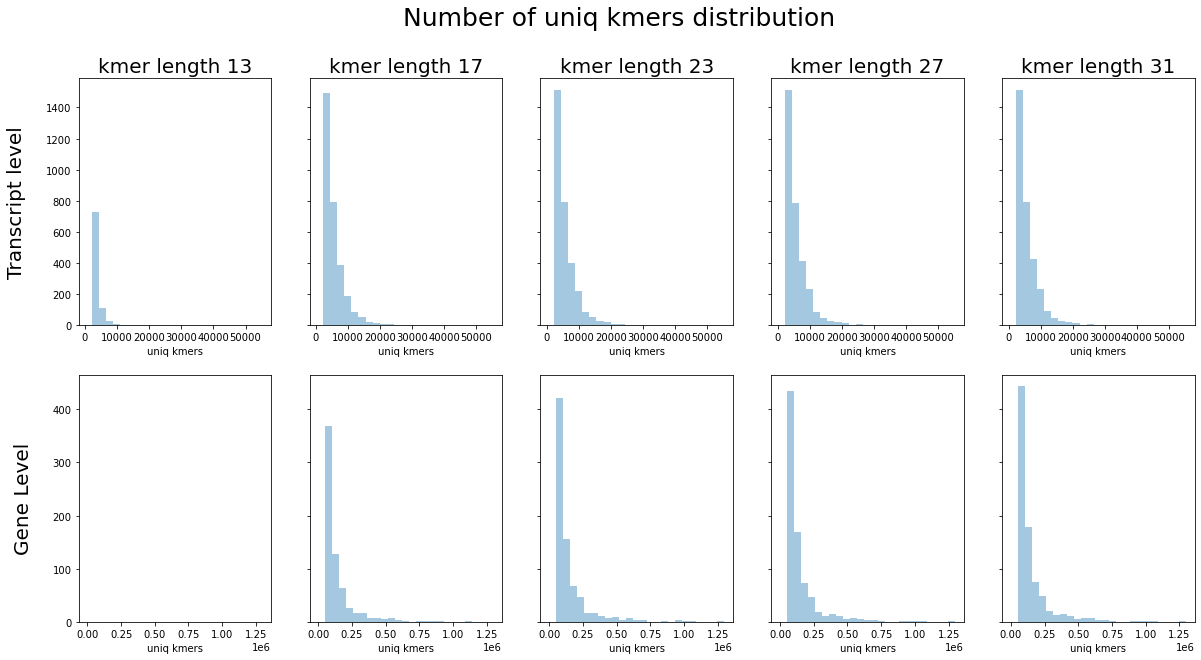

In [5]:
fig, big_axs = plt.subplots(2, 5,
                            sharey="row",
                            sharex="row",
                            figsize=[20,10]);

fig.suptitle("Number of uniq kmers distribution", fontsize=25);
big_axs[0][0].set_ylabel("Transcript level", fontsize=20, labelpad=20);
big_axs[1][0].set_ylabel("Gene Level", fontsize=20, labelpad=20);

mkpt = max((pd.to_numeric(UIPT[l]["uniq kmers"], errors="coerce").max() for l in kmer_lens))
mkpg = max((pd.to_numeric(UIPG[l]["uniq kmers"], errors="coerce").max() for l in kmer_lens))

for i, l in enumerate(kmer_lens):
    sns.distplot(pd.to_numeric(UIPT[l]["uniq kmers"], errors="coerce"),
                 bins=bins_limits(0, mkpt),
                 ax=big_axs[0][i],
                 kde=False);
    big_axs[0][i].set_title(f"kmer length {l}", fontsize=20);
    sns.distplot(pd.to_numeric(UIPG[l]["uniq kmers"], errors="coerce"),
                 bins=bins_limits(0, mkpg),
                 ax=big_axs[1][i],
                 kde=False);
plt.show();

We note that the distribution of uniq kmers is similar to the distribution of distinct kmers (scaled down) and that almost no 13-mer is uniq at gene level.

## Distribution of uniqness indexes

Let's now analyze the distribution of UIPT and UIPG

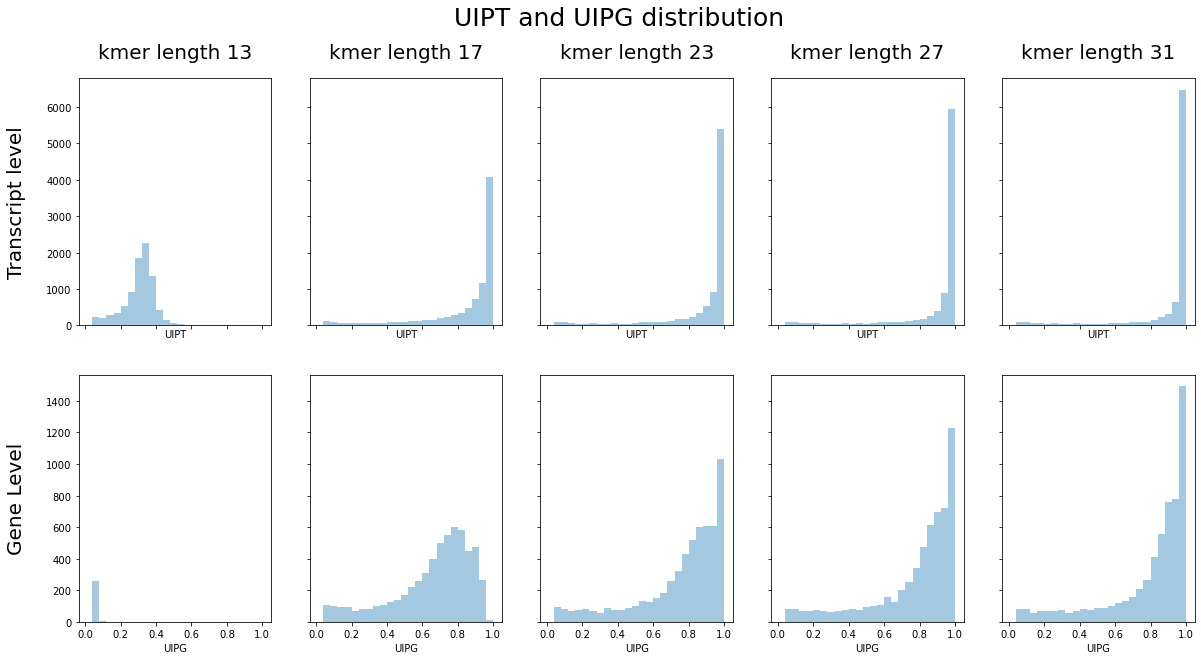

In [6]:
fig, big_axs = plt.subplots(2, 5,
                            sharex=True,
                            sharey="row",
                            figsize=[20,10]);

fig.suptitle("UIPT and UIPG distribution", fontsize=25);
big_axs[0][0].set_ylabel("Transcript level", fontsize=20, labelpad=20);
big_axs[1][0].set_ylabel("Gene Level", fontsize=20, labelpad=20);

mkpt = max((pd.to_numeric(UIPT[l]["UIPT"], errors="coerce").max() for l in kmer_lens))
mkpg = max((pd.to_numeric(UIPG[l]["UIPG"], errors="coerce").max() for l in kmer_lens))

for i, l in enumerate(kmer_lens):
    sns.distplot(pd.to_numeric(UIPT[l]["UIPT"], errors="coerce"),
                 bins=bins_limits(0, mkpt),
                 ax=big_axs[0][i],
                 kde=False);
    big_axs[0][i].set_title(f"kmer length {l}", fontsize=20, pad=20);
    sns.distplot(pd.to_numeric(UIPG[l]["UIPG"], errors="coerce"),
                 bins=bins_limits(0, mkpg),
                 ax=big_axs[1][i],
                 kde=False);
plt.show();

These graphs show that UIPG and UIPT are quite different and that UIPG tends to be smaller than UIPT.
Moreover, the smaller the value of k, the more UIPG and UIPT are small.

Finally, we note thatfor kmer size equal to 23, 27 and 31 the distribution of UIPT is similar and that the same applies to UIPG.

## Shark precision and recall

As stated in the paper, the value of precision and recall of `shark` varies depending on the kmer size.
We ran `shark` on all 9403 genes for kmer size 13, 17, and 31 and both in single and multi mode.

Since the distribution of UIPG and UIPT for kmer sizes 23, 27, and 31 are similar on this dataset, we didn't run shark with kmer size 23 and 27 and use kmer size 31 as reference for all the 3 values.

Precision and recall on each gene values for kmer size `l` and mode `mode` are stored in file `PR_data/{mode}/k{l}.{mode}.PR_per_gene.tsv`.

Let's first load in memory these values.

In [7]:
pr = {}
pr_lengths = (13, 17, 31)

for m in modes:
    pr[m] = {}
    for l in pr_lengths:
        p = pd.read_csv(f"PR_data/{m}/k{l}.{m}.PR_per_gene.tsv", sep='\t', index_col=0)
        pr[m][l] = p

We now remove genes that have 0 TP, 0 FP, and 0 FN (thus undefined precision and recall) from the dataframe to avoid skewing the analysis.

Note that the number of rows removed by each dataframe is different since the number of TP varies depending on the value of k.

In [8]:
for m in modes:
    for l in pr_lengths:
        fdf = pr[m][l]
        fdf = fdf[(fdf["TP"] != 0) | (fdf["FN"] != 0) | (fdf["FP"] != 0)]
        pr[m][l] = fdf
for m in modes:
    for l in pr_lengths:
        print(f"Entries for k={l} and mode={m}: {len(pr[m][l])}")

Entries for k=13 and mode=single: 6195
Entries for k=17 and mode=single: 6121
Entries for k=31 and mode=single: 6161
Entries for k=13 and mode=multi: 8463
Entries for k=17 and mode=multi: 8105
Entries for k=31 and mode=multi: 7733


Surprisingly, the number of entries increases with k in single mode, whereas it decreases for increasing k in multi mode.

Let's now visualize the precision and recall distribution depending on the mode and the kmer length.

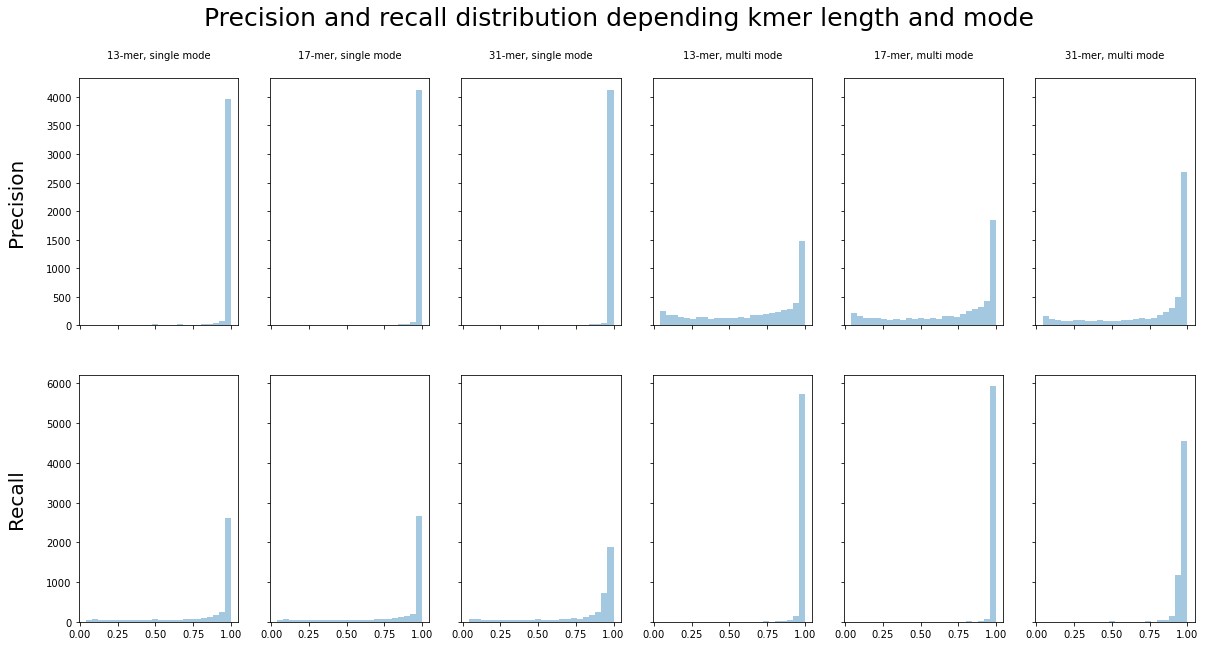

In [9]:
fig, big_axs = plt.subplots(2, 6,
                            sharey="row",
                            sharex=True,
                            figsize=[20,10]);

fig.suptitle("Precision and recall distribution depending kmer length and mode", fontsize=25);
big_axs[0][0].set_ylabel("Precision", fontsize=20, labelpad=20);
big_axs[1][0].set_ylabel("Recall", fontsize=20, labelpad=20);

for i, m in enumerate(modes):
    for j, l in enumerate(pr_lengths):
        sns.distplot(pr[m][l]['P'], bins=bins_limits(0, 1.0),
                     ax=big_axs[0][i*3 + j],
                     axlabel=False,
                     kde=False);
        sns.distplot(pr[m][l]['R'], bins=bins_limits(0, 1.0),
                     ax=big_axs[1][i*3 + j],
                     axlabel=False,
                     kde=False);
        big_axs[0][i*3 + j].set_title(f"{l}-mer, {m} mode", fontsize=10, pad=20);
plt.show();

As reported in the main manuscript, these graphs show that single mode has higher precision whereas multi mode has higher recall.

Moreover, increasing the value of k increases the precision of the tool but decreases its recall.

# UIPG analysis

We now analyze whether the value of UIPG affect the precision and recall of `shark`.

First, we split the genes into 3 classes based on their value of UIPG (low UIPG, medium UIPG, and high UIPG).
A gene is assigned to a class as follows:
* if UIPG is smaller or equal to 0.10 then the class is low UIPG
* if UIPG is greater or equal to 0.90 then the class is high UIPG
* otherwise the class i medium UIPG

Note that we will perform the same analysis for both mode runs and for all the kmer sizes.

In [10]:
# First we join the precision and recall dataframes with
# the dataframe that includes UIPG
uipg_groups = {}

UIPG_labels = ["low UIPG", "medium UIPG", "high UIPG"]

for m in modes:
    uipg_groups[m] = {}
    for l in pr_lengths:
        pr_uipg_df = pr[m][l].join(UIPG[l])
        uipg_groups[m][l] = pr_uipg_df.groupby(pd.cut(pr_uipg_df["UIPG"],
                                                      bins=(0, 0.10, 0.90, 1.0),
                                                      labels=UIPG_labels))

Let's now take a look at how many genes are in each group.

In [11]:
_d = {(m, k, t) : uipg_groups[m][k].size()[t] for k in pr_lengths \
                                              for m in modes \
                                              for t in uipg_groups[m][l].groups.keys()}
_uipg_df_cnts =  \
      pd.DataFrame(_d.values(), index=pd.MultiIndex.from_tuples(_d.keys()))[0].unstack()[UIPG_labels]
display(_uipg_df_cnts)

low UIPG  medium UIPG  high UIPG
multi  13      5568            3          0
       17       361         4848        268
       31       287         2996       2011
single 13      4498            3          0
       17       266         3971        247
       31       213         2503       1814

As we can see from the previous table, the higher the kmer size is the more genes fall in higher UIPG classes.
Let's now look at average precision and recall values in each class for each mode and for each kmer size.

Note that there are no elements in the high UIPG class for kmer size equal to 13.

In [12]:
_dp = {(m, k, t) : uipg_groups[m][k].P.mean()[t] for k in pr_lengths \
                                                 for m in modes \
                                                 for t in uipg_groups[m][l].groups.keys()}
_uipg_df_p =  \
      pd.DataFrame(_dp.values(), index=pd.MultiIndex.from_tuples(_dp.keys()))[0].unstack()[UIPG_labels] \
           .style.set_table_attributes("style='display:inline'") \
           .set_caption("Precision")

_dr = {(m, k, t) : uipg_groups[m][k].R.mean()[t] for k in pr_lengths \
                                                 for m in modes \
                                                 for t in uipg_groups[m][l].groups.keys()}
_uipg_df_r =  \
      pd.DataFrame(_dr.values(), index=pd.MultiIndex.from_tuples(_dr.keys()))[0].unstack()[UIPG_labels] \
           .style.set_table_attributes("style='display:inline'") \
           .set_caption("Recall")

display_html("<center>" + _uipg_df_p._repr_html_() + " " + _uipg_df_r._repr_html_() + "</center>", raw=True)

Precision low UIPG medium UIPG high UIPG 
 
 multi 
 13 
 0.474972 
 1.000000 
 nan 
 
 
 17 
 0.315717 
 0.528714 
 0.883735 
 
 
 31 
 0.350676 
 0.556376 
 0.771694 
 
 
 single 
 13 
 0.919981 
 1.000000 
 nan 
 
 
 17 
 0.621150 
 0.956883 
 0.982457 
 
 
 31 
 0.577615 
 0.930524 
 0.965596 
 
 Recall low UIPG medium UIPG high UIPG 
 
 multi 
 13 
 0.776057 
 1.000000 
 nan 
 
 
 17 
 0.695247 
 0.802555 
 0.911090 
 
 
 31 
 0.684976 
 0.784255 
 0.855290 
 
 
 single 
 13 
 0.792401 
 1.000000 
 nan 
 
 
 17 
 0.136293 
 0.830873 
 0.975040 
 
 
 31 
 0.103507 
 0.707121 
 0.920641

We can say that, whathever the values of mode and the kmer size are, the higher the value of UIPG is the higher precision and recall are.

We also note that, in in most cases precision and recall decrease for increasing values of kmer size in the same class.

# UIPT analysis

Similarly to the previous section, 
we now analyze whether the value of UIPT affect the precision and recall of `shark`.

First, we split the genes into 3 classes based on their value of UIPT (low UIPT, medium UIPT, and high UIPT).
A gene is assigned to a class as follows:
* if UIPT is smaller or equal to 0.10 then the class is low UIPT
* if UIPT is greater or equal to 0.90 then the class is high UIPT
* otherwise the class i medium UIPT

Note that we will perform the same analysis for both mode runs and for all the kmer sizes.

In [13]:
# First we join the precision and recall dataframes with
# the dataframe that includes UIPT
uipt_groups = {}

UIPT_labels = ["low UIPT", "medium UIPT", "high UIPT"]

for m in modes:
    uipt_groups[m] = {}
    for l in pr_lengths:
        pr_uipt_df = pr[m][l].join(UIPT[l])
        uipt_groups[m][l] = pr_uipt_df.groupby(pd.cut(pd.to_numeric(pr_uipt_df["UIPT"], errors="coerce"),
                                                      bins=(0, 0.10, 0.90, 1.0),
                                                      labels=UIPT_labels))

Again let's look at how many elements are in each group.

In [14]:
_d = {(m, k, t) : uipt_groups[m][k].size()[t] for k in pr_lengths \
                                              for m in modes \
                                              for t in uipt_groups[m][l].groups.keys()}
_uipt_df_cnts =  \
      pd.DataFrame(_d.values(), index=pd.MultiIndex.from_tuples(_d.keys()))[0].unstack()[UIPT_labels]
display(_uipt_df_cnts)

low UIPT  medium UIPT  high UIPT
multi  13       672         7475          0
       17       305         2642       4856
       31       205         1368       5866
single 13       427         5610          0
       17       191         1901       3879
       31       128         1021       4866

And print the precision and recall values of each group.

In [15]:
_dp = {(m, k, t) : uipt_groups[m][k].P.mean()[t] for k in pr_lengths \
                                                 for m in modes \
                                                 for t in uipt_groups[m][l].groups.keys()}
_uipt_df_p =  \
      pd.DataFrame(_dp.values(), index=pd.MultiIndex.from_tuples(_dp.keys()))[0].unstack()[UIPT_labels] \
           .style.set_table_attributes("style='display:inline'") \
           .set_caption("Precision")

_dr = {(m, k, t) : uipt_groups[m][k].R.mean()[t] for k in pr_lengths \
                                                 for m in modes \
                                                 for t in uipt_groups[m][l].groups.keys()}
_uipt_df_r =  \
      pd.DataFrame(_dr.values(), index=pd.MultiIndex.from_tuples(_dr.keys()))[0].unstack()[UIPT_labels] \
           .style.set_table_attributes("style='display:inline'") \
           .set_caption("Recall")

display_html("<center>" + _uipt_df_p._repr_html_() + " " + _uipt_df_r._repr_html_() + "</center>", raw=True)

Precision low UIPT medium UIPT high UIPT 
 
 multi 
 13 
 0.251501 
 0.469031 
 nan 
 
 
 17 
 0.208115 
 0.456713 
 0.557650 
 
 
 31 
 0.189371 
 0.461953 
 0.647901 
 
 
 single 
 13 
 0.469429 
 0.708163 
 nan 
 
 
 17 
 0.481236 
 0.623203 
 0.759942 
 
 
 31 
 0.417672 
 0.578528 
 0.734852 
 
 Recall low UIPT medium UIPT high UIPT 
 
 multi 
 13 
 0.571269 
 0.726953 
 nan 
 
 
 17 
 0.578197 
 0.701783 
 0.787992 
 
 
 31 
 0.546332 
 0.699417 
 0.789805 
 
 
 single 
 13 
 0.193773 
 0.622352 
 nan 
 
 
 17 
 0.105948 
 0.484539 
 0.679155 
 
 
 31 
 0.044781 
 0.358669 
 0.635141

As per UIPG, the higher the value of UIPT is the higher precision and recall are.

We also note that, in in most cases precision and recall decrease for increasing values of kmer size in the same class.